## Load libraries

In [38]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import sparse_categorical_crossentropy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Load data_No Cv

In [27]:
train_idg = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 30,  
    zoom_range = 0.2, 
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip = True,
)
test_idg = ImageDataGenerator(
    rescale = 1./255.
)
val_idg = ImageDataGenerator(
    rescale=1./255.
)

IMG_SIZE = (224, 224)

train = train_idg.flow_from_directory('./input/chest_xray/train', 
                                      class_mode='binary',
                                      color_mode="grayscale",
                                      target_size = IMG_SIZE
                                     )
test = test_idg.flow_from_directory('./input/chest_xray/test', 
                                    class_mode='binary',
                                    color_mode="grayscale",
                                    target_size = IMG_SIZE
                                   )
val = val_idg.flow_from_directory('./input/chest_xray/val',
                                  class_mode='binary',
                                  color_mode="grayscale",
                                  target_size = IMG_SIZE
                                 )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [28]:
trainX, trainY = train.next()
testX, testY = test.next()
valX, valY = val.next()

print(len(trainX), len(trainY))#32 32

32 32


In [29]:
print('Train X=%s Y=%s' %(trainX.shape, trainY.shape))
print('Test X=%s Y=%s' %(testX.shape, testY.shape))
print('Val X=%s Y=%s' %(valX.shape, valY.shape))

Train X=(32, 224, 224, 1) Y=(32,)
Test X=(32, 224, 224, 1) Y=(32,)
Val X=(16, 224, 224, 1) Y=(16,)


## Modeling_NO Cv

In [30]:
model = Sequential()
model.add( Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(224, 224, 1)))
model.add( Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add( MaxPooling2D(pool_size=(3,3)))  

model.add( Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add( Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add( MaxPooling2D(pool_size=(3,3)))   

model.add( Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add( Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add( MaxPooling2D(pool_size=(2,2)))   

model.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add( Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add( MaxPooling2D(pool_size=(2,2)))   

model.add( Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add( Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add( MaxPooling2D(pool_size=(2,2)))      

model.add(Flatten())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='softmax'))# 1 or 2

# compile model
optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 224, 224, 8)       400       
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 224, 224, 8)       3144      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 74, 74, 16)        3216      
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 74, 74, 16)        6416      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 24, 24, 32)      

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [12]:
history = model.fit(train ,batch_size=8, epochs = 50 , validation_data = val ,callbacks = [learning_rate_reduction])

Epoch 1/50
163/163 [==============================] - 281s 2s/step - loss: 0.0000e+00 - accuracy: 0.7429 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 282s 2s/step - loss: 0.0000e+00 - accuracy: 0.7429 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 282s 2s/step - loss: 0.0000e+00 - accuracy: 0.7429 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 4/50
163/163 [==============================] - 283s 2s/step - loss: 0.0000e+00 - accuracy: 0.7429 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/50
163/163 [==============================] - 283s 2s/step - loss: 0.0000e+00 - accuracy: 0.7429 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 6/50
163/163 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7429
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
163/163 [==============================] - 283s 2s/step - loss: 

In [13]:
print("Loss of the model is - " , model.evaluate(testX,testY)[0])
print("Accuracy of the model is - " , model.evaluate(testX,testY)[1]*100 , "%")

1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6875
Loss of the model is -  0.0
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6875
Accuracy of the model is -  68.75 %


## Load data_CV

In [32]:
path = './input/chest_xray/'
# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'

# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg') #1341
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')#3875

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')#234
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')#390

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')#8
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')#8

In [33]:
# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

## Visualize distribution of cases_CV

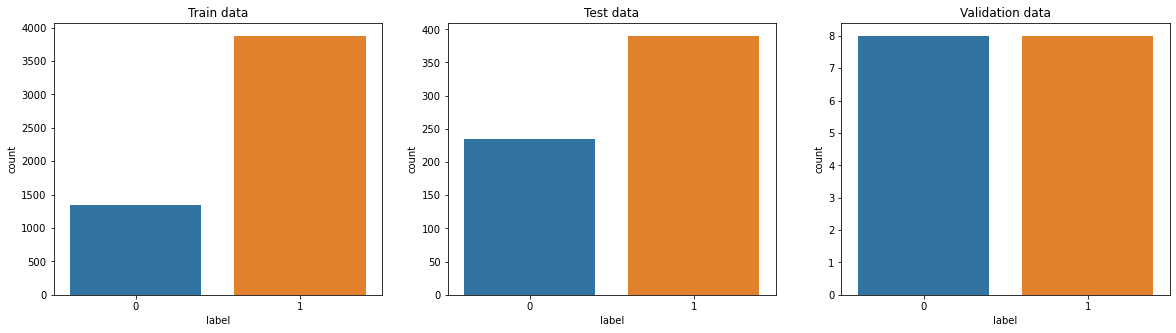

In [34]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

**여기서 class_weight 조절의 필요성을 생각해볼 필요가 있음.. 
**학습 데이터를 보면 정상 자료가 비정상 환자 자료에 비에 부족한 편  
**딥러닝에서 클래스 불균형을 다루는 방법  

현실 데이터에는 클래스 불균형 (class imbalance) 문제가 자주 있다.   
어떤 데이터에서 각 클래스 (주로 범주형 반응 변수) 가 갖고 있는 데이터의 양에 차이가 큰 경우,   
"현실 데이터" 에 클래스 불균형 문제가 있다고 말한다.  

- 더욱 큰 비중 (weight) 를 두고 정확한 예측을 할 수 있도록 만들어야한다.  
- 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 하는 방법  
- 정상환자 클래스의 데이터에 관해서는 loss 가 더 크도록 만드는 것이다.  

## Data preprocessing_CV

process_data - 이미지 로드, 크기 조정, 그레이스케일로 변환, 정규화 및 텐서 흐름에 필요한 차원으로 재조정  
compose_dataset - 이미지를 반복하여 2 Numpy 배열 생성. 첫째는 이미지 자체를 매트릭스로 포함하며, 둘째는 레이블을 포함함

In [35]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (244, 244))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (244,244,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [36]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 244, 244, 1), Labels shape: (5216,)
Test data shape: (624, 244, 244, 1), Labels shape: (624,)
Validation data shape: (16, 244, 244, 1), Labels shape: (16,)


### Weight decay
가중치 감소는 학습 중에 가중치가 큰 것에 대해서는 일종의 패널티를 부과해 과적합의 위험을 줄이는 방법이다. 가중치의 제곱 법칙(L2 법칙; 많이 사용된다)를 손실함수에 더해 손실함수 값이 더 커지게 한다. 그만큼 가중치가 커지는 것을 억제하기 되는 것이다.



L2 법칙은 1/2곱하기 λ(람다) 곱하기 W제곱 이다.

람다는 정규화의 세기를 조절하는 하이퍼파라미터이다.

람다를 크게 설정할수록 가중치에 대한 페널티가 커진다. 


출처: https://sacko.tistory.com/45 [데이터 분석하는 문과생, 싸코]

In [39]:
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
weights = {0: weights[0], 1: weights[1]}
print(weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [40]:
weights = compute_class_weight('balanced', np.unique(y_test), y_test)
weights = {0: weights[0], 1: weights[1]}
print(weights)

{0: 1.3333333333333333, 1: 0.8}


In [42]:
weights = compute_class_weight('balanced', np.unique(y_val), y_val)
weights = {0: weights[0], 1: weights[1]}
print(weights)

{0: 1.0, 1: 1.0}


## Data augmentation_CV

In [9]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Kfold  Cross Validation

In [11]:
kfold = KFold(n_splits=5, shuffle=True)

In [12]:
# Model configuration
img_width, img_height, img_num_channels = 244, 244, 1 #gray image channel = 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
acc_per_fold = []
loss_per_fold = []

## Modeling_CV

In [13]:
def get_model():
    model = Sequential([
        Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(244, 244, 1)),
        Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3,3)),
        
        Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'),
        Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3,3)),
        
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Flatten(),
        Flatten(),
        Dropout(0.2),
        Dense(2, activation='softmax')        
    ])
    
    # compile model
    optimizer = Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [19]:
for i, (train, test) in enumerate(kfold.split(X_train, y_train), 1):
   
    print(f'training model for Kfold #{i}')
    callback = EarlyStopping(monitor='loss', patience=6)
    
    model = get_model()

    # Fit data to model
    #model.fit(datagen.flow(X_train[train], y_train[train], batch_size=4),
    history = model.fit(X_train[train], y_train[train],
                        validation_data=(X_train[test], y_train[test]),
                        batch_size = 8,
                        epochs=10,
                        callbacks=[callback],
                        verbose = 1,
                        class_weight={0:6.0, 1:0.5}
                       )
    
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {i}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    filename = './models/model_cnn' + str(i) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

training model for Kfold #1
Epoch 1/10
522/522 [==============================] - 342s 649ms/step - loss: 0.8570 - accuracy: 0.3424 - val_loss: 0.6475 - val_accuracy: 0.7490
Epoch 2/10
522/522 [==============================] - 348s 667ms/step - loss: 0.3092 - accuracy: 0.8492 - val_loss: 0.2306 - val_accuracy: 0.9148
Epoch 3/10
522/522 [==============================] - 375s 719ms/step - loss: 0.2023 - accuracy: 0.9081 - val_loss: 0.1385 - val_accuracy: 0.9435
Epoch 4/10
522/522 [==============================] - 339s 650ms/step - loss: 0.1632 - accuracy: 0.9274 - val_loss: 0.3925 - val_accuracy: 0.8707
Epoch 5/10
522/522 [==============================] - 332s 635ms/step - loss: 0.1302 - accuracy: 0.9347 - val_loss: 0.2421 - val_accuracy: 0.9148
Epoch 6/10
522/522 [==============================] - 331s 634ms/step - loss: 0.1266 - accuracy: 0.9414 - val_loss: 0.1131 - val_accuracy: 0.9598
Epoch 7/10
522/522 [==============================] - 331s 634ms/step - loss: 0.0911 - accuracy:

In [15]:
# == Provide average scores ==
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0973026305437088 - Accuracy: 96.64750695228577%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 96.81751608848572 (+- 0.9459172001129958)
> Loss: 0.1020585335791111
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0957726538181305 - Accuracy: 97.3154366016388%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 96.81751608848572 (+- 0.9459172001129958)
> Loss: 0.1020585335791111
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 0.05007432773709297 - Accuracy: 98.37008714675903%
---------------------------------------------------

In [20]:
def avg(list):
    return (sum(list)/len(list))

print("Test loss  : {}".format(avg(loss_per_fold)))
print("Test accuracy : {}".format(avg(acc_per_fold)))

Test loss  : 0.10004557259380817
Test accuracy : 96.702601313591


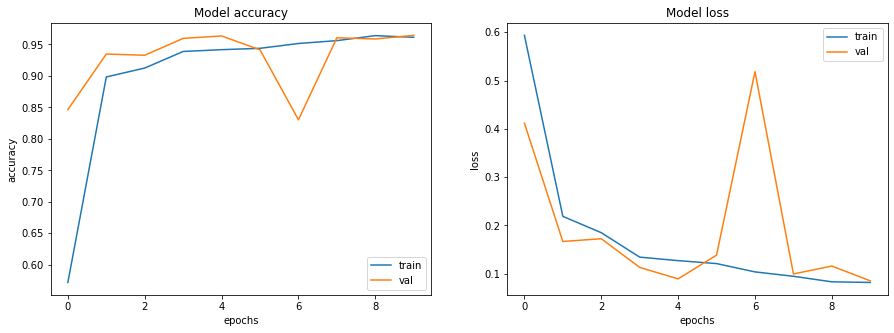

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])